In [29]:
%qtconsole

In [47]:
%matplotlib inline
from __future__ import print_function

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import random

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import normalize
from sklearn.grid_search import GridSearchCV
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm

from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split

In [107]:
microclimate_train = pd.read_csv('dataset/Training set Microclimate (2 hour intervals).csv',
                                 index_col=0, parse_dates=[0])

microclimate_test = pd.read_csv('dataset/Test set Microclimate (2 hour intervals).csv',
                                index_col=0, parse_dates=[0])

labels = pd.read_csv('dataset/Target Variable Water Yield.csv',
                     index_col=0, parse_dates=[0])

submission_format = pd.read_csv('dataset/Submission format.csv',
                                index_col=0, parse_dates=[0])

microclimate_5min = pd.read_csv('dataset/Training set Microclimate (5 minute intervals).csv',
                                 index_col=0, parse_dates=[0])

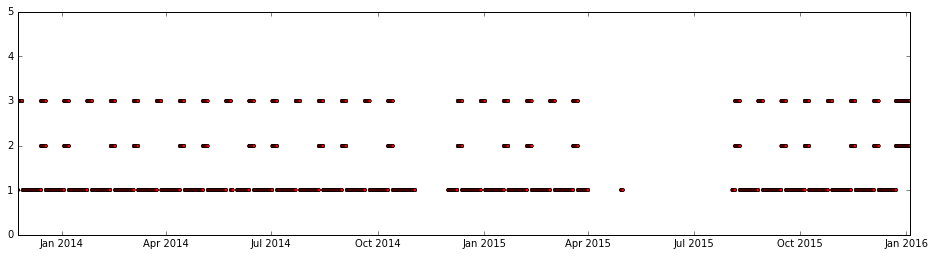

In [4]:
X_time = microclimate_train.copy()
y_time = labels.copy()

X_test_time = microclimate_test.copy()
y_test_time = submission_format.copy()

fig, ax = plt.subplots(figsize=(16, 4))

ax.plot_date(X_time.index, [1 for i in xrange(y_time.shape[0])], c='r', ms=3)
ax.plot_date(X_test_time.index, [2 for i in xrange(X_test_time.shape[0])], c='r', ms=3)
ax.plot_date(y_test_time.index, [3 for i in xrange(y_test_time.shape[0])], c='r', ms=3)
ax.set_ylim([0, 5])

plt.show()

In [60]:
X_time = microclimate_train.copy()
y_time = labels.copy()
X_joint = microclimate_train.copy()

for i in [2]:
    offset = i
    y_pretime = labels.copy()
    y_pretime.index = y_pretime.index + pd.DateOffset(hours=offset)
    y_pretime = y_pretime.rename(columns={'yield': 'pre_yield_' + str(offset) + '_hours'})
    y_joint = pd.concat([y_time, y_pretime], axis=1, join='inner')
    X_joint = pd.concat([X_joint, y_joint], axis=1, join='outer')
    X_joint = X_joint.drop(labels='yield', axis=1)

In [61]:
X_train_pre_yield, X_test_pre_yield, y_train_pre_yield, y_test_pre_yield = train_test_split(X_joint,
                                                    y_time,
                                                    test_size=0.3, random_state=100)

In [62]:
steps_random_forest = [('imputer', Imputer()),
         ('pca', PCA()),
         ('rf', ensemble.RandomForestRegressor())]
pipe_random_forest = Pipeline(steps_random_forest)

# create the grid search
params = {
    'pca__n_components': range(2, X_train_pre_yield.shape[1]),
    'imputer__strategy': ['mean', 'median', 'most_frequent'],
    'rf__n_estimators': [5, 10, 20],
}

In [63]:
estimator_random_forest = GridSearchCV(pipe_random_forest, param_grid=params, n_jobs=-1, verbose=1)
estimator_random_forest.fit(X_train_pre_yield, y_train_pre_yield.values.ravel())

y_hat_pre_yield_random_forest = estimator_random_forest.predict(X_test_pre_yield)
rmse_pre_yield_random_forest = np.sqrt(mean_squared_error(y_test_pre_yield, y_hat_pre_yield_random_forest))
rmse_pre_yield_random_forest

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   21.8s finished


1.7266732423220803

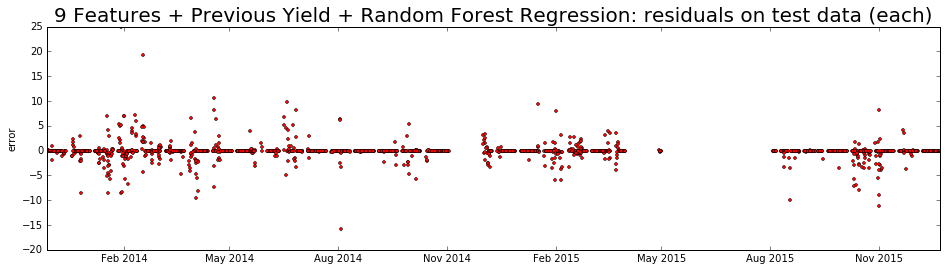

In [64]:
fig, ax = plt.subplots(figsize=(16, 4))
err = y_test_pre_yield.values.ravel() - y_hat_pre_yield_random_forest

ax.plot_date(y_test_pre_yield.index, err, c='r', ms=3)
ax.set_title('9 Features + Previous Yield + Random Forest Regression: residuals on test data (each)', fontsize=20)
ax.set_ylabel('error')

plt.show()

<div class="alert alert-danger">
Classifier.
</div>

In [65]:
X_time = microclimate_train.copy()
y_time = labels.copy()

X_time = X_time.drop(labels=X_time.index[0:4], axis=0).copy()
y_time = y_time.drop(labels=y_time.index[0:4], axis=0).copy()

for timestamp in y_time.index:
    if y_time.loc[timestamp]['yield'] > 0:
        y_time.loc[timestamp]['yield'] = 1

X_time.fillna(method='pad')
        
for timestamp in X_time.index:
    if np.isnan(X_time.loc[timestamp]['percip_mm']):
        X_time = X_time.drop(labels=timestamp, axis=0).copy()
        y_time = y_time.drop(labels=timestamp, axis=0).copy()
    elif np.isnan(X_time.loc[timestamp]['gusts_ms']):
        X_time = X_time.drop(labels=timestamp, axis=0).copy()
        y_time = y_time.drop(labels=timestamp, axis=0).copy()
    elif np.isnan(X_time.loc[timestamp]['leafwet460_min']):
        X_time.loc[timestamp]['leafwet460_min'] = 0      

normalize(X_time, copy=False)

array([[ 0.        ,  0.00091682,  0.01788412, ...,  0.00739163,
         0.27372533,  0.00662224],
       [ 0.        ,  0.00092281,  0.01775545, ...,  0.00761486,
         0.27220775,  0.0069001 ],
       [ 0.        ,  0.00081023,  0.01875063, ...,  0.00745248,
         0.27227188,  0.00675496],
       ..., 
       [ 0.        ,  0.00078708,  0.03060067, ...,  0.00748404,
         0.15971649,  0.00572088],
       [ 0.        ,  0.00081195,  0.02876198, ...,  0.00978416,
         0.1629566 ,  0.00888447],
       [ 0.        ,  0.00084619,  0.02856601, ...,  0.01075866,
         0.14647318,  0.00986602]])

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_time,
                                                    y_time,
                                                    test_size=0.3, random_state=100)

In [67]:
estimator = ensemble.AdaBoostClassifier(n_estimators=40,learning_rate=1)
#estimator = svm.SVC(C=1.0, kernel='poly', degree=30, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=None, random_state=None)
estimator.fit(X_train, y_train)
y_hat = estimator.predict(X_test)

wrong_predict_count = 0
zero_to_one = 0
one_to_zero = 0
one_to_one = 0
zero_to_zero = 0
for i in xrange(y_test.shape[0]):
    if y_test.values[i] != y_hat[i]:
        wrong_predict_count += 1
        if y_test.values[i] == 0:
            zero_to_one += 1
        else:
            one_to_zero += 1
    else:
        if y_test.values[i] == 0:
            zero_to_zero += 1
        else:
            one_to_one += 1
            
print('test size =', y_test.shape[0])
# print('non-zeron in y_hat =', np.count_nonzero(y_hat))
print('right_predict_count =', y_test.shape[0] - wrong_predict_count)
print('in right_predict_count: zero_to_zero =', zero_to_zero)
print('in right_predict_count: one_to_one =', one_to_one)
print('wrong_predict_count =', wrong_predict_count)
print('in wrong_predict_count: zero_to_one =', zero_to_one)
print(1.0*zero_to_one/(zero_to_one+zero_to_zero))
print('in wrong_predict_count: one_to_zero =', one_to_zero)
print(1.0*one_to_zero/(one_to_one+one_to_zero))

print(1.0*55/373)

estimator.score(X_test, y_test)
# estimator.staged_score(X_test, y_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_hat))
# rmse

# X_joint = pd.concat([X_train, y_train], axis=1, join='outer')
# X_joint.head(n=1000)

/Users/Shauro/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test size = 1734
right_predict_count = 1638
in right_predict_count: zero_to_zero = 1318
in right_predict_count: one_to_one = 320
wrong_predict_count = 96
in wrong_predict_count: zero_to_one = 43
0.0315944158707
in wrong_predict_count: one_to_zero = 53
0.142091152815
0.14745308311


0.94463667820069208

<div class="alert alert-danger">
Regression.
</div>

In [76]:
X_time = microclimate_train.copy()
y_time = labels.copy()

X_time = X_time.drop(labels=X_time.index[0:4], axis=0).copy()
y_time = y_time.drop(labels=y_time.index[0:4], axis=0).copy()
        
X_time.fillna(method='pad')
        
for timestamp in X_time.index:
    if np.isnan(X_time.loc[timestamp]['percip_mm']):
        X_time = X_time.drop(labels=timestamp, axis=0).copy()
        y_time = y_time.drop(labels=timestamp, axis=0).copy()
    elif np.isnan(X_time.loc[timestamp]['gusts_ms']):
        X_time = X_time.drop(labels=timestamp, axis=0).copy()
        y_time = y_time.drop(labels=timestamp, axis=0).copy()
    elif np.isnan(X_time.loc[timestamp]['leafwet460_min']):
        X_time.loc[timestamp]['leafwet460_min'] = 0      

normalize(X_time, copy=False)

array([[ 0.        ,  0.00091682,  0.01788412, ...,  0.00739163,
         0.27372533,  0.00662224],
       [ 0.        ,  0.00092281,  0.01775545, ...,  0.00761486,
         0.27220775,  0.0069001 ],
       [ 0.        ,  0.00081023,  0.01875063, ...,  0.00745248,
         0.27227188,  0.00675496],
       ..., 
       [ 0.        ,  0.00078708,  0.03060067, ...,  0.00748404,
         0.15971649,  0.00572088],
       [ 0.        ,  0.00081195,  0.02876198, ...,  0.00978416,
         0.1629566 ,  0.00888447],
       [ 0.        ,  0.00084619,  0.02856601, ...,  0.01075866,
         0.14647318,  0.00986602]])

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_time,
                                                    y_time,
                                                    test_size=0.3, random_state=100)

In [84]:
estimator = ensemble.RandomForestRegressor()
estimator.fit(X_train, y_train)
y_hat_regression = estimator.predict(X_test)


# steps_random_forest = [('imputer', Imputer()),
#          ('pca', PCA()),
#          ('rf', ensemble.RandomForestRegressor())]
# pipe_random_forest = Pipeline(steps_random_forest)

# # create the grid search
# params = {
#     'pca__n_components': range(2, X_train.shape[1]),
#     'imputer__strategy': ['mean', 'median', 'most_frequent'],
#     'rf__n_estimators': [5, 10, 20]
# }
# estimator = GridSearchCV(pipe_random_forest, param_grid=params, n_jobs=-1, verbose=1)
# estimator.fit(X_train, y_train.values.ravel())

# y_hat_regression = estimator.predict(X_test)

/Users/Shauro/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [82]:
# for i in xrange(y_hat.shape[0]):
#     if y_hat[i] == 1:
#         y_hat[i] = y_hat_regression[i]
        
# rmse = np.sqrt(mean_squared_error(y_test, y_hat))
# rmse

2.0701903248284124

In [80]:
estimator = ensemble.AdaBoostClassifier(n_estimators=40,learning_rate=1)
#estimator = svm.SVC(C=1.0, kernel='poly', degree=30, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=None, random_state=None)
estimator.fit(X_train, y_train.values.ravel())
y_hat = estimator.predict(X_test)

wrong_predict_count = 0
zero_to_one = 0
one_to_zero = 0
one_to_one = 0
zero_to_zero = 0
for i in xrange(y_test.shape[0]):
    if y_test.values[i] != y_hat[i]:
        wrong_predict_count += 1
        if y_test.values[i] == 0:
            zero_to_one += 1
        else:
            one_to_zero += 1
    else:
        if y_test.values[i] == 0:
            zero_to_zero += 1
        else:
            one_to_one += 1
            
print('test size =', y_test.shape[0])
# print('non-zeron in y_hat =', np.count_nonzero(y_hat))
print('right_predict_count =', y_test.shape[0] - wrong_predict_count)
print('in right_predict_count: zero_to_zero =', zero_to_zero)
print('in right_predict_count: one_to_one =', one_to_one)
print('wrong_predict_count =', wrong_predict_count)
print('in wrong_predict_count: zero_to_one =', zero_to_one)
print(1.0*zero_to_one/(zero_to_one+zero_to_zero))
print('in wrong_predict_count: one_to_zero =', one_to_zero)
print(1.0*one_to_zero/(one_to_one+one_to_zero))

print(1.0*55/373)

estimator.score(X_test, y_test)
# estimator.staged_score(X_test, y_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_hat))
# rmse

# X_joint = pd.concat([X_train, y_train], axis=1, join='outer')
# X_joint.head(n=1000)

ValueError: Unknown label type: array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

In [86]:
y_classifier = np.copy(y_hat)
y_regression = np.copy(y_hat_regression)

predict_total = y_test.copy()

for i in xrange(y_regression.shape[0]):
    if abs(y_regression[i]) < 0.01 :
        y_regression[i] = 0
# print(y_regression)

predict_total['y_classider'] = y_classifier
predict_total['y_regression'] = y_regression

# for i in xrange(y_regression.shape[0]):
#     predict_total.append((y_classifier[i], y_regression[i], y_test.values[i]))
# print(predict_total)

wrong_predict_count = 0
zero_to_one = 0
one_to_zero = 0
one_to_one = 0
zero_to_zero = 0

for i in xrange(y_test.shape[0]):
    if y_test.values[i] == 0:
        if y_regression[i] == 0:
            zero_to_zero += 1
        else:
            wrong_predict_count += 1
            zero_to_one += 1
    else:
        if y_regression[i] == 0:
            wrong_predict_count += 1
            one_to_zero += 1
        else:
            one_to_one += 1
            
print('test size =', y_test.shape[0])
# print('non-zeron in y_hat =', np.count_nonzero(y_hat))
print('right_predict_count =', y_test.shape[0] - wrong_predict_count)
print('in right_predict_count: zero_to_zero =', zero_to_zero)
print('in right_predict_count: one_to_one =', one_to_one)
print('wrong_predict_count =', wrong_predict_count)
print('in wrong_predict_count: zero_to_one =', zero_to_one)
print(1.0*zero_to_one/(zero_to_one+zero_to_zero))
print('in wrong_predict_count: one_to_zero =', one_to_zero)
print(1.0*one_to_zero/(one_to_one+one_to_zero))

rmse = np.sqrt(mean_squared_error(y_test, y_regression))
print('loss =', rmse)
        
predict_total.head(n=1734)

predict_total.to_csv("./three_combine.csv")

test size = 1734
right_predict_count = 1571
in right_predict_count: zero_to_zero = 1234
in right_predict_count: one_to_one = 337
wrong_predict_count = 163
in wrong_predict_count: zero_to_one = 127
0.0933137398971
in wrong_predict_count: one_to_zero = 36
0.0965147453083
loss = 2.22166143322


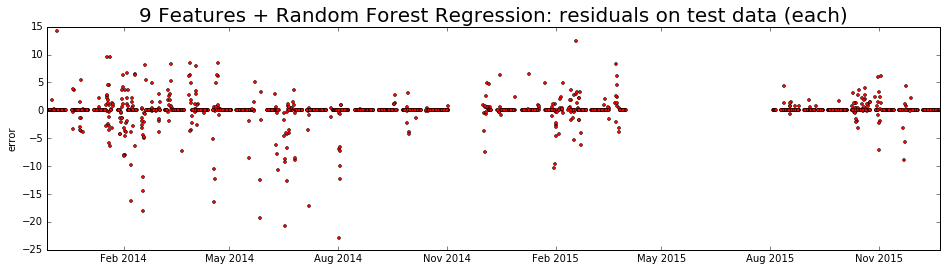

In [87]:
fig, ax = plt.subplots(figsize=(16, 4))
err = y_regression - y_test.values.ravel()

ax.plot_date(y_test.index, err, c='r', ms=3)
ax.set_title('9 Features + Random Forest Regression: residuals on test data (each)', fontsize=20)
ax.set_ylabel('error')

plt.show()

# cc = 0
# for i in xrange(err.shape[0]):
#     if y_regression[i] - y_test.values[0][i] < 0:
#         cc += 1

<div class="alert alert-danger">
Add previous yield.
</div>

In [95]:
X_time = microclimate_train.copy()
y_time = labels.copy()

X_time = X_time.drop(labels=X_time.index[0:4], axis=0).copy()
y_time = y_time.drop(labels=y_time.index[0:4], axis=0).copy()
        
X_time.fillna(method='pad')
        
for timestamp in X_time.index:
    if np.isnan(X_time.loc[timestamp]['percip_mm']):
        X_time = X_time.drop(labels=timestamp, axis=0).copy()
        y_time = y_time.drop(labels=timestamp, axis=0).copy()
    elif np.isnan(X_time.loc[timestamp]['gusts_ms']):
        X_time = X_time.drop(labels=timestamp, axis=0).copy()
        y_time = y_time.drop(labels=timestamp, axis=0).copy()
    elif np.isnan(X_time.loc[timestamp]['leafwet460_min']):
        X_time.loc[timestamp]['leafwet460_min'] = 0      

normalize(X_time, copy=False)

array([[ 0.        ,  0.00091682,  0.01788412, ...,  0.00739163,
         0.27372533,  0.00662224],
       [ 0.        ,  0.00092281,  0.01775545, ...,  0.00761486,
         0.27220775,  0.0069001 ],
       [ 0.        ,  0.00081023,  0.01875063, ...,  0.00745248,
         0.27227188,  0.00675496],
       ..., 
       [ 0.        ,  0.00078708,  0.03060067, ...,  0.00748404,
         0.15971649,  0.00572088],
       [ 0.        ,  0.00081195,  0.02876198, ...,  0.00978416,
         0.1629566 ,  0.00888447],
       [ 0.        ,  0.00084619,  0.02856601, ...,  0.01075866,
         0.14647318,  0.00986602]])

In [96]:
X_joint = X_time.copy()
y_new = y_time.copy()
for i in [2]:
    offset = i
    y_pretime = y_new.copy()
    y_pretime.index = y_pretime.index + pd.DateOffset(hours=offset)
    y_pretime = y_pretime.rename(columns={'yield': 'pre_yield_' + str(offset) + '_hours'})
    y_joint = pd.concat([y_new, y_pretime], axis=1, join='inner')
    X_joint = pd.concat([X_joint, y_joint], axis=1, join='outer')
    X_joint = X_joint.drop(labels='yield', axis=1)
    
for timestamp in X_time.index:
    for i in [2]:
        if np.isnan(X_joint.loc[timestamp]['pre_yield_' + str(i) + '_hours']):
            X_joint = X_joint.drop(labels=timestamp, axis=0).copy()
            y_new = y_new.drop(labels=timestamp, axis=0).copy()

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X_joint,
                                                    y_new,
                                                    test_size=0.3, random_state=100)

In [91]:
y_for_ada = y_train.copy()

for timestamp in y_for_ada.index:
    if y_for_ada.loc[timestamp]['yield'] > 0:
        y_for_ada.loc[timestamp]['yield'] = 1

estimator = ensemble.AdaBoostClassifier(n_estimators=40,learning_rate=1)
#estimator = svm.SVC(C=1.0, kernel='poly', degree=30, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=None, random_state=None)
estimator.fit(X_train, y_for_ada)
y_hat = estimator.predict(X_test)

wrong_predict_count = 0
zero_to_one = 0
one_to_zero = 0
one_to_one = 0
zero_to_zero = 0
for i in xrange(y_test.shape[0]):
    if y_test.values[i] == 0:
        if y_regression[i] == 0:
            zero_to_zero += 1
        else:
            wrong_predict_count += 1
            zero_to_one += 1
    else:
        if y_regression[i] == 0:
            wrong_predict_count += 1
            one_to_zero += 1
        else:
            one_to_one += 1
            
print('test size =', y_test.shape[0])
# print('non-zeron in y_hat =', np.count_nonzero(y_hat))
print('right_predict_count =', y_test.shape[0] - wrong_predict_count)
print('in right_predict_count: zero_to_zero =', zero_to_zero)
print('in right_predict_count: one_to_one =', one_to_one)
print('wrong_predict_count =', wrong_predict_count)
print('in wrong_predict_count: zero_to_one =', zero_to_one)
print(1.0*zero_to_one/(zero_to_one+zero_to_zero))
print('in wrong_predict_count: one_to_zero =', one_to_zero)
print(1.0*one_to_zero/(one_to_one+one_to_zero))

print(1.0*55/373)

# estimator.score(X_test, y_test)
# estimator.staged_score(X_test, y_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_hat))
# rmse

# X_joint = pd.concat([X_train, y_train], axis=1, join='outer')
# X_joint.head(n=1000)

/Users/Shauro/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test size = 1723
right_predict_count = 1103
in right_predict_count: zero_to_zero = 987
in right_predict_count: one_to_one = 116
wrong_predict_count = 620
in wrong_predict_count: zero_to_one = 344
0.25845229151
in wrong_predict_count: one_to_zero = 276
0.704081632653
0.14745308311


In [104]:
estimator = ensemble.RandomForestRegressor()
estimator.fit(X_train, y_train)
y_hat_regression = estimator.predict(X_test)

/Users/Shauro/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [105]:
y_classifier = np.copy(y_hat)
y_regression = np.copy(y_hat_regression)

predict_total = y_test.copy()

for i in xrange(y_regression.shape[0]):
    if abs(y_regression[i]) < 0.01 :
        y_regression[i] = 0
# print(y_regression)

predict_total['y_classider'] = y_classifier
predict_total['y_regression'] = y_regression

# for i in xrange(y_regression.shape[0]):
#     predict_total.append((y_classifier[i], y_regression[i], y_test.values[i]))
# print(predict_total)

wrong_predict_count = 0
zero_to_one = 0
one_to_zero = 0
one_to_one = 0
zero_to_zero = 0

for i in xrange(y_test.shape[0]):
    if y_test.values[i] == 0:
        if y_regression[i] == 0:
            zero_to_zero += 1
        else:
            wrong_predict_count += 1
            zero_to_one += 1
    else:
        if y_regression[i] == 0:
            wrong_predict_count += 1
            one_to_zero += 1
        else:
            one_to_one += 1
            
print('test size =', y_test.shape[0])
# print('non-zeron in y_hat =', np.count_nonzero(y_hat))
print('right_predict_count =', y_test.shape[0] - wrong_predict_count)
print('in right_predict_count: zero_to_zero =', zero_to_zero)
print('in right_predict_count: one_to_one =', one_to_one)
print('wrong_predict_count =', wrong_predict_count)
print('in wrong_predict_count: zero_to_one =', zero_to_one)
print(1.0*zero_to_one/(zero_to_one+zero_to_zero))
print('in wrong_predict_count: one_to_zero =', one_to_zero)
print(1.0*one_to_zero/(one_to_one+one_to_zero))

rmse = np.sqrt(mean_squared_error(y_test, y_regression))
print('loss =', rmse)
        
predict_total.head(n=1734)

predict_total.to_csv("./three_combine_pre_yield.csv")

test size = 1723
right_predict_count = 1593
in right_predict_count: zero_to_zero = 1232
in right_predict_count: one_to_one = 361
wrong_predict_count = 130
in wrong_predict_count: zero_to_one = 99
0.0743801652893
in wrong_predict_count: one_to_zero = 31
0.0790816326531
loss = 1.81517187136


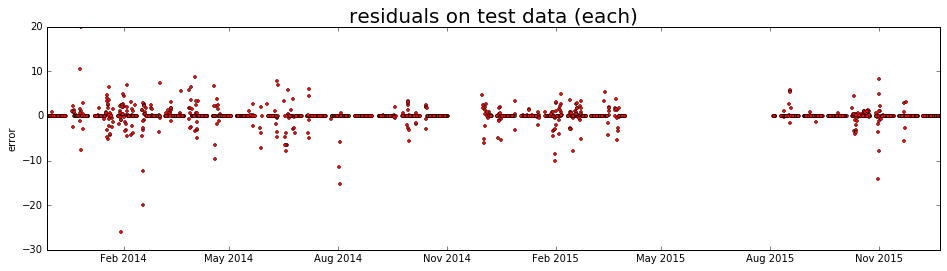

In [106]:
fig, ax = plt.subplots(figsize=(16, 4))
err = y_regression - y_test.values.ravel()

ax.plot_date(y_test.index, err, c='r', ms=3)
ax.set_title('residuals on test data (each)', fontsize=20)
ax.set_ylabel('error')

plt.show()

# cc = 0
# for i in xrange(err.shape[0]):
#     if y_regression[i] - y_test.values[0][i] < 0:
#         cc += 1

<div class="alert alert-danger">
Read training set for 5 minites interval.
</div>

In [113]:
X_5min = microclimate_5min.copy()

X_time = microclimate_train.copy()
y_time = labels.copy()

X_time = X_time.drop(labels=X_time.index[0:4], axis=0).copy()
y_time = y_time.drop(labels=y_time.index[0:4], axis=0).copy()
        
X_time.fillna(method='pad')
        
for timestamp in X_time.index:
    if np.isnan(X_time.loc[timestamp]['percip_mm']):
        X_time = X_time.drop(labels=timestamp, axis=0).copy()
        y_time = y_time.drop(labels=timestamp, axis=0).copy()
    elif np.isnan(X_time.loc[timestamp]['gusts_ms']):
        X_time = X_time.drop(labels=timestamp, axis=0).copy()
        y_time = y_time.drop(labels=timestamp, axis=0).copy()
    elif np.isnan(X_time.loc[timestamp]['leafwet460_min']):
        X_time.loc[timestamp]['leafwet460_min'] = 0      

normalize(X_time, copy=False)

array([[ 0.        ,  0.00091682,  0.01788412, ...,  0.00739163,
         0.27372533,  0.00662224],
       [ 0.        ,  0.00092281,  0.01775545, ...,  0.00761486,
         0.27220775,  0.0069001 ],
       [ 0.        ,  0.00081023,  0.01875063, ...,  0.00745248,
         0.27227188,  0.00675496],
       ..., 
       [ 0.        ,  0.00078708,  0.03060067, ...,  0.00748404,
         0.15971649,  0.00572088],
       [ 0.        ,  0.00081195,  0.02876198, ...,  0.00978416,
         0.1629566 ,  0.00888447],
       [ 0.        ,  0.00084619,  0.02856601, ...,  0.01075866,
         0.14647318,  0.00986602]])

In [193]:
X_joint = X_time.copy()
y_new = y_time.copy()
for i in [2]:
    offset = i
    y_pretime = y_new.copy()
    y_pretime.index = y_pretime.index + pd.DateOffset(hours=offset)
    y_pretime = y_pretime.rename(columns={'yield': 'pre_yield_' + str(offset) + '_hours'})
    y_joint = pd.concat([y_new, y_pretime], axis=1, join='inner')
    X_joint = pd.concat([X_joint, y_joint], axis=1, join='outer')
    X_joint = X_joint.drop(labels='yield', axis=1)
    
for i in [60]:
    X_joint['pre_' + str(i) + '_min_wind_dir'] = np.nan
    
for timestamp in X_time.index:
    for i in [2]:
        if np.isnan(X_joint.loc[timestamp]['pre_yield_' + str(i) + '_hours']):
            X_joint = X_joint.drop(labels=timestamp, axis=0).copy()
            y_new = y_new.drop(labels=timestamp, axis=0).copy()
            
    # Add pre_x_min_wind_dir features.
    for i in [60]:
        pre_time = timestamp - pd.DateOffset(minutes=i)
        if pre_time in X_5min.index:
            pre_wind_dir = X_5min.loc[pre_time]['wind_dir']
            if isinstance(pre_wind_dir, pd.Series):
                pre_wind_dir = pre_wind_dir.mean()
            if timestamp in X_joint.index:
                if not np.isnan(pre_wind_dir):
                    X_joint.loc[timestamp]['pre_' + str(i) + '_min_wind_dir'] = pre_wind_dir
                else:
                    X_joint = X_joint.drop(labels=timestamp, axis=0).copy()
                    y_new = y_new.drop(labels=timestamp, axis=0).copy()
        elif timestamp in X_joint.index:
            X_joint = X_joint.drop(labels=timestamp, axis=0).copy()
            y_new = y_new.drop(labels=timestamp, axis=0).copy()

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X_joint,
                                                    y_new,
                                                    test_size=0.3, random_state=100)

In [204]:
estimator = ensemble.RandomForestRegressor()
estimator.fit(X_train, y_train)
y_hat_regression = estimator.predict(X_test)

/Users/Shauro/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [205]:
y_hat_regression_for_ada = y_train.copy()

for timestamp in y_for_ada.index:
    if y_for_ada.loc[timestamp]['yield'] > 0:
        y_for_ada.loc[timestamp]['yield'] = 1

estimator = ensemble.AdaBoostClassifier(n_estimators=40,learning_rate=1)
#estimator = svm.SVC(C=1.0, kernel='poly', degree=30, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=None, random_state=None)
estimator.fit(X_train, y_for_ada)
y_hat = estimator.predict(X_test)

wrong_predict_count = 0
zero_to_one = 0
one_to_zero = 0
one_to_one = 0
zero_to_zero = 0
for i in xrange(y_test.shape[0]):
    if y_test.values[i] == 0:
        if y_regression[i] == 0:
            zero_to_zero += 1
        else:
            wrong_predict_count += 1
            zero_to_one += 1
    else:
        if y_regression[i] == 0:
            wrong_predict_count += 1
            one_to_zero += 1
        else:
            one_to_one += 1
            
print('test size =', y_test.shape[0])
# print('non-zeron in y_hat =', np.count_nonzero(y_hat))
print('right_predict_count =', y_test.shape[0] - wrong_predict_count)
print('in right_predict_count: zero_to_zero =', zero_to_zero)
print('in right_predict_count: one_to_one =', one_to_one)
print('wrong_predict_count =', wrong_predict_count)
print('in wrong_predict_count: zero_to_one =', zero_to_one)
print(1.0*zero_to_one/(zero_to_one+zero_to_zero))
print('in wrong_predict_count: one_to_zero =', one_to_zero)
print(1.0*one_to_zero/(one_to_one+one_to_zero))

print(1.0*55/373)

# estimator.score(X_test, y_test)
# estimator.staged_score(X_test, y_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_hat))
# rmse

# X_joint = pd.concat([X_train, y_train], axis=1, join='outer')
# X_joint.head(n=1000)

/Users/Shauro/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test size = 1722
right_predict_count = 1068
in right_predict_count: zero_to_zero = 978
in right_predict_count: one_to_one = 90
wrong_predict_count = 654
in wrong_predict_count: zero_to_one = 370
0.274480712166
in wrong_predict_count: one_to_zero = 284
0.75935828877
0.14745308311


In [206]:
y_classifier = np.copy(y_hat)
y_regression = np.copy(y_hat_regression)

predict_total = y_test.copy()

for i in xrange(y_regression.shape[0]):
    if abs(y_regression[i]) < 0.01 :
        y_regression[i] = 0
# print(y_regression)

predict_total['y_classider'] = y_classifier
predict_total['y_regression'] = y_regression

# for i in xrange(y_regression.shape[0]):
#     predict_total.append((y_classifier[i], y_regression[i], y_test.values[i]))
# print(predict_total)

wrong_predict_count = 0
zero_to_one = 0
one_to_zero = 0
one_to_one = 0
zero_to_zero = 0

for i in xrange(y_test.shape[0]):
    if y_test.values[i] == 0:
        if y_regression[i] == 0:
            zero_to_zero += 1
        else:
            wrong_predict_count += 1
            zero_to_one += 1
    else:
        if y_regression[i] == 0:
            wrong_predict_count += 1
            one_to_zero += 1
        else:
            one_to_one += 1
            
print('test size =', y_test.shape[0])
# print('non-zeron in y_hat =', np.count_nonzero(y_hat))
print('right_predict_count =', y_test.shape[0] - wrong_predict_count)
print('in right_predict_count: zero_to_zero =', zero_to_zero)
print('in right_predict_count: one_to_one =', one_to_one)
print('wrong_predict_count =', wrong_predict_count)
print('in wrong_predict_count: zero_to_one =', zero_to_one)
print(1.0*zero_to_one/(zero_to_one+zero_to_zero))
print('in wrong_predict_count: one_to_zero =', one_to_zero)
print(1.0*one_to_zero/(one_to_one+one_to_zero))

rmse = np.sqrt(mean_squared_error(y_test, y_regression))
print('loss =', rmse)
        
predict_total.head(n=1734)

predict_total.to_csv("./three_combine_pre_yield_pre_wind_dir.csv")

test size = 1722
right_predict_count = 1581
in right_predict_count: zero_to_zero = 1242
in right_predict_count: one_to_one = 339
wrong_predict_count = 141
in wrong_predict_count: zero_to_one = 106
0.0786350148368
in wrong_predict_count: one_to_zero = 35
0.0935828877005
loss = 1.75212279815


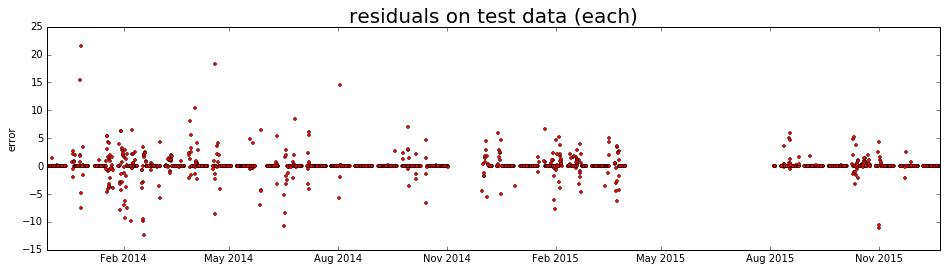

In [207]:
fig, ax = plt.subplots(figsize=(16, 4))
err = y_regression - y_test.values.ravel()

ax.plot_date(y_test.index, err, c='r', ms=3)
ax.set_title('residuals on test data (each)', fontsize=20)
ax.set_ylabel('error')

plt.show()

# cc = 0
# for i in xrange(err.shape[0]):
#     if y_regression[i] - y_test.values[0][i] < 0:
#         cc += 1

In [ ]:
for i in [2,4,6,8,18,20,22]:
    offset = i
    y_pretime = labels.copy()
    y_pretime.index = y_pretime.index + pd.DateOffset(hours=offset)
    y_pretime = y_pretime.rename(columns={'yield': 'pre_yield_' + str(offset) + '_hours'})
    y_joint = pd.concat([y_time, y_pretime], axis=1, join='inner')
    X_joint = pd.concat([X_joint, y_joint], axis=1, join='outer')
    X_joint = X_joint.drop(labels='yield', axis=1)

In [ ]:
X_time = microclimate_train.copy()
y_time = labels.copy()
X_joint = microclimate_train.copy()

for i in [2,4,6,8,18,20,22]:
    offset = i
    y_pretime = labels.copy()
    y_pretime.index = y_pretime.index + pd.DateOffset(hours=offset)
    y_pretime = y_pretime.rename(columns={'yield': 'pre_yield_' + str(offset) + '_hours'})
    y_joint = pd.concat([y_time, y_pretime], axis=1, join='inner')
    X_joint = pd.concat([X_joint, y_joint], axis=1, join='outer')
    X_joint = X_joint.drop(labels='yield', axis=1)